# Plot citation statistics for CMIP overview publications

In [1]:
# Updates
# PJD  5 Apr 2023 - Started

## imports

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import copy
import datetime
import os

## define time info

In [41]:
timeNow = datetime.datetime.now()
timeFormat = timeNow.strftime("%y%m%dT%H%M%S")
print("timeFormat:", timeFormat)

timeFormat: 230405T161551


## define input data

In [42]:
labels = ["AMIP1", "CMIP1", "CMIP2", "CMIP3", "CMIP5", "CMIP6"]

# AMIP1 Gates et al., 1992 BAMS
# 1992, 1993 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:A1992KD66500003
amip1 = [0, 1, 18, 50, 54, 60, 67, 60, 60, 39, 38, 48, 23, 22, 23, 21, 20, 14, 17, 21, 16,
        21, 25, 27, 33, 22, 27, 27, 25, 23, 20, 2]
# create pad index
pad = [np.nan]*len(amip1)
# Year since publication
yrSincePublication = np.arange(0, len(amip1))

# CMIP1 Meehl et al., 1995 BAMS
# 1995, 1996 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:A1995RG21000008
cmip1 = [0, 3, 6, 5, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 4, 3, 1]
cmip1a = copy.deepcopy(pad)
cmip1a[:len(cmip1)] = cmip1
cmip1 = cmip1a
del(cmip1a)

# CMIP2 Meehl et al., 2005 BAMS
# 2005 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000226970100024
cmip2 = [5, 5, 7, 12, 12, 7, 15, 18, 21, 18, 21, 16, 11, 7, 10, 22, 13, 9, 1]
cmip2a = copy.deepcopy(pad)
cmip2a[:len(cmip2)] = cmip2
cmip2 = cmip2a
del(cmip2a)

# CMIP3 Meehl et al., 2007 BAMS
# 2007 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000250166400004
cmip3 = [3, 28, 102, 131, 189, 267, 319, 207, 188, 145, 123, 104, 89, 108, 70, 67, 10]
cmip3a = copy.deepcopy(pad)
cmip3a[:len(cmip3)] = cmip3
cmip3 = cmip3a
del(cmip3a)

# CMIP5 Taylor et al., 2012 BAMS
# 2012 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000303110900004
cmip5 = [98, 503, 619, 838, 919, 1010, 1251, 1289, 1251, 1177, 856, 130]
cmip5a = copy.deepcopy(pad)
cmip5a[:len(cmip5)] = cmip5
cmip5 = cmip5a
del(cmip5a)

# CMIP6 Eyring et al., 2016 GMD
# 2016 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000376937800013
cmip6 = [23, 58, 112, 155, 544, 928, 1265, 240]
cmip6a = copy.deepcopy(pad)
cmip6a[:len(cmip6)] = cmip6
cmip6 = cmip6a
del(cmip6a)
'''
print("yrSincePublication:", yrSincePublication)
print("amip1:", amip1)
print("cmip1:", cmip1)
print("cmip2:", cmip2)
print("cmip3:", cmip3)
print("cmip5:", cmip5)
print("cmip6:", cmip6)
'''

'\nprint("yrSincePublication:", yrSincePublication)\nprint("amip1:", amip1)\nprint("cmip1:", cmip1)\nprint("cmip2:", cmip2)\nprint("cmip3:", cmip3)\nprint("cmip5:", cmip5)\nprint("cmip6:", cmip6)\n'

## first plot

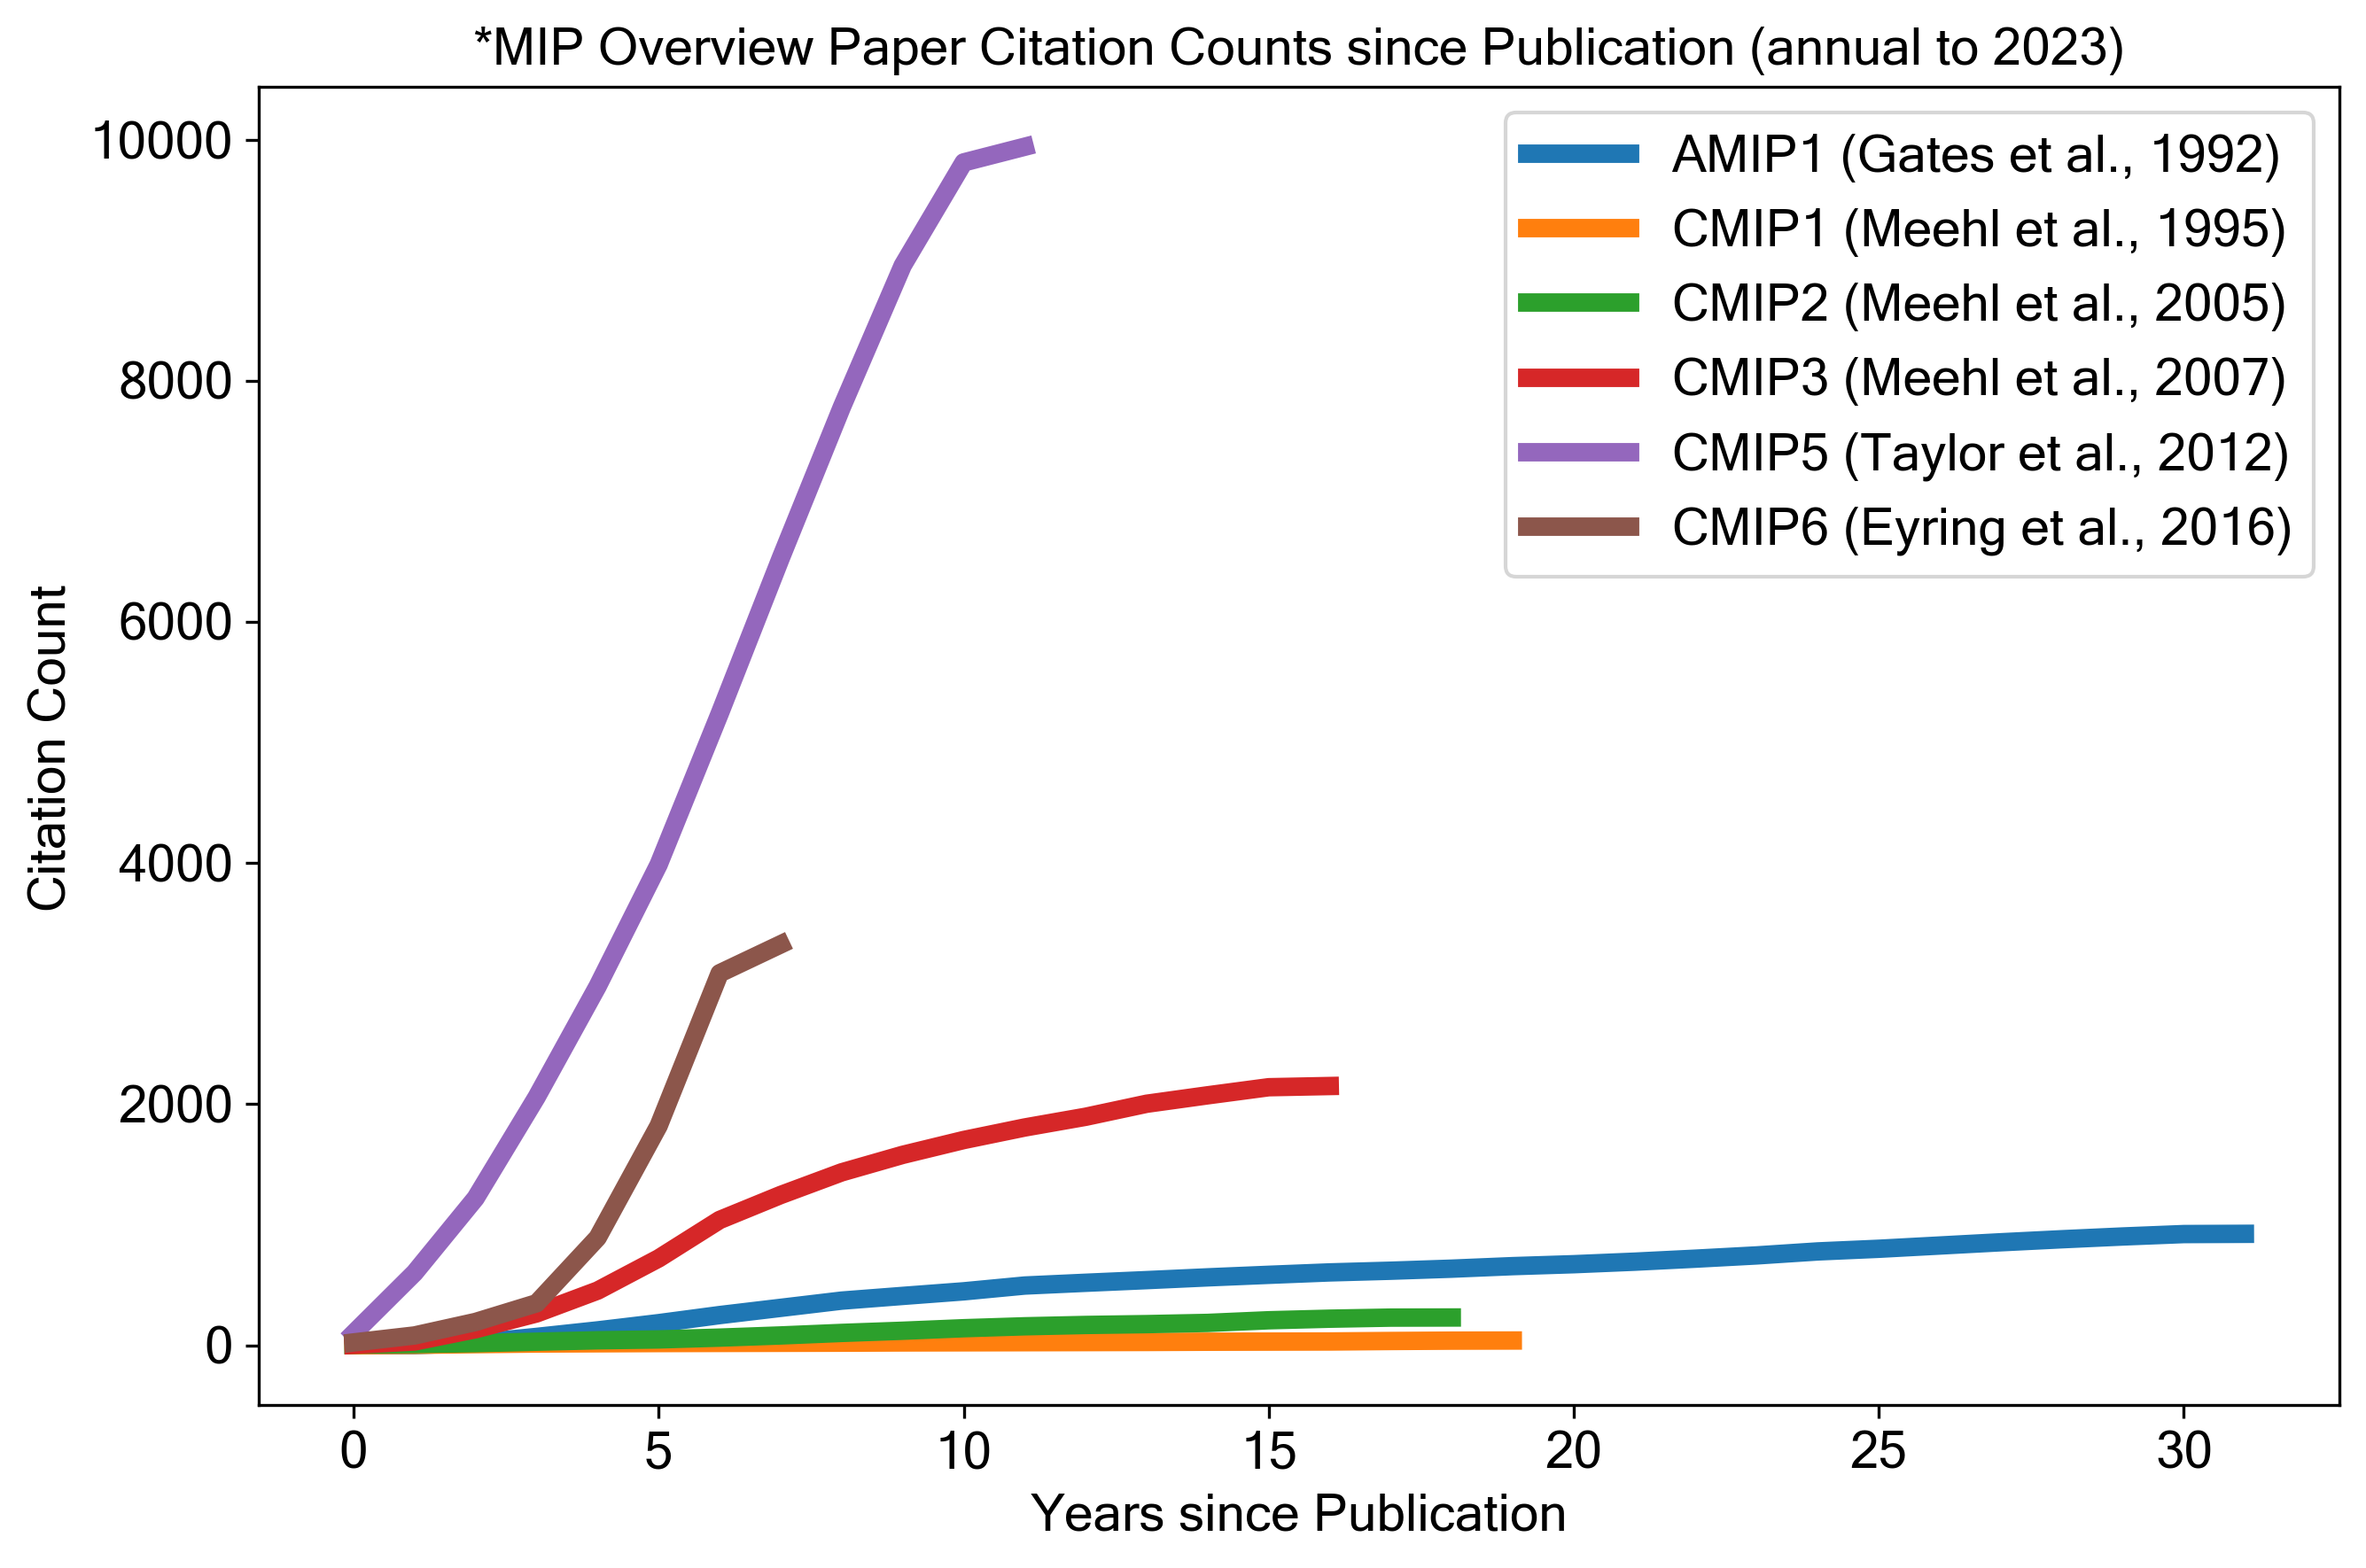

In [43]:
# set inputs
x = np.arange(len(labels))  # label locations
width = 0.25  # width of the bars
fontsize = 14
lineWidth = 5
fontName = "Microsoft Sans Serif"

# initialize canvas
fig, ax = plt.subplots(figsize=(9, 6), dpi=300)

# plot from year 1
line1 = plt.plot(yrSincePublication, np.cumsum(amip1), linewidth=lineWidth, label="AMIP1 (Gates et al., 1992)")
line2 = plt.plot(yrSincePublication, np.cumsum(cmip1), linewidth=lineWidth, label="CMIP1 (Meehl et al., 1995)")
line3 = plt.plot(yrSincePublication, np.cumsum(cmip2), linewidth=lineWidth, label="CMIP2 (Meehl et al., 2005)")
line4 = plt.plot(yrSincePublication, np.cumsum(cmip3), linewidth=lineWidth, label="CMIP3 (Meehl et al., 2007)")
line5 = plt.plot(yrSincePublication, np.cumsum(cmip5), linewidth=lineWidth, label="CMIP5 (Taylor et al., 2012)")
line6 = plt.plot(yrSincePublication, np.cumsum(cmip6), linewidth=lineWidth, label="CMIP6 (Eyring et al., 2016)")

# pretty things up - add text for labels, title and custom x-axis tick labels, etc.
ax.set_title('*MIP Overview Paper Citation Counts since Publication (annual to 2023)',
             fontname=fontName, fontsize=fontsize)
ax.set_ylabel('Citation Count', fontname=fontName, fontsize=fontsize)
plt.yticks(fontname=fontName, fontsize=fontsize)
ax.set_xlabel("Years since Publication", fontname=fontName, fontsize=fontsize)
plt.xticks(fontname=fontName, fontsize=fontsize)
ax.legend(prop={"family": fontName, "size": fontsize})

# fill canvas
fig.tight_layout()

# display, save and close
plt.show()
fig.savefig("_".join([timeFormat,"CMIPOverviewPaperCitations-Counts.png"]))